In [1]:

#######################################################################
#                                                                     #
#  Copyright 2016 Theodore D Drivas                                   #
#                                                                     #
#  This file is part of pyTurbTraj.                                   #
#                                                                     #
#  pyTurbTraj is free software: you can redistribute it and/or modify #
#  it under the terms of the GNU General Public License as published  #
#  by the Free Software Foundation, either version 3 of the License,  #
#  or (at your option) any later version.                             #
#                                                                     #
#  pyTurbTraj is distributed in the hope that it will be useful,      #
#  but WITHOUT ANY WARRANTY; without even the implied warranty of     #
#  MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the      #
#  GNU General Public License for more details.                       #
#                                                                     #
#  You should have received a copy of the GNU General Public License  #
#  along with pyTurbTraj.  If not, see <http://www.gnu.org/licenses/> #
#                                                                     #
#######################################################################

import numpy as np
import scipy
import matplotlib.ticker as mtick

%matplotlib nbagg
import matplotlib.pyplot as plt

from tools import *

In [424]:
# for kernel density estimation

from scipy.stats.distributions import norm
from sklearn.neighbors import KernelDensity
from scipy.stats import gaussian_kde
from scipy.special import erf

def kde_scipy(x, x_grid, bandwidth=0.2, **kwargs):
    """Kernel Density Estimation with Scipy"""
    # Note that scipy weights its bandwidth by the covariance of the
    # input data.  To make the results comparable to the other methods,
    # we divide the bandwidth by the sample standard deviation here.
    kde = gaussian_kde(x, bw_method=bandwidth / x.std(ddof=1), **kwargs)
    return kde.evaluate(x_grid)

def approximatePDF(bw, data, grid):
    doubledData = np.concatenate((-data, data), axis=0)
    doubledGrid = np.concatenate((-grid[::-1], grid), axis=0)
    pdf = kde_scipy(doubledData, doubledGrid, bandwidth = bw)
    return  2*pdf/np.trapz(pdf)

def coarse_data(data, N):
    return np.random.choice(data, N, replace=False)

def KL_dist(pk, qk):
    return scipy.stats.entropy(pk, qk, base=None)

def L1_dist(pk, qk):
    return np.trapz(abs(pk-qk))

def subsampled_dist(Ns, replicas, bw, data, grid):
    realization_KL = np.zeros(shape=(replicas, len(Ns)))
    realization_L1 = np.zeros(shape=(replicas, len(Ns)))
    subsampledPDFs = np.zeros(shape=(len(Ns), 2*len(grid)))
    pk = approximatePDF(bw, data, grid)
    for i in range(replicas):
        for II in range(len(Ns)):
            subsampledPDFs[II,:] = approximatePDF(bw, coarse_data(data, Ns[II]), grid)
            qk = subsampledPDFs[II,:]
            realization_KL[i,II] = KL_dist(pk, qk)
            realization_L1[i,II] = L1_dist(pk, qk)
    averageKL = np.average(realization_KL, axis = 0)
    averageL1 = np.average(realization_L1, axis = 0)
    return averageL1, averageKL

def get_pairwise_dist(deltas, data, grid):
    approxPDFs = np.zeros(shape=(len(deltas), 2*len(grid)))
    for II in range(len(deltas)):
        approxPDFs[II,:] = approximatePDF(deltas[II], data, grid)
    KLdistances = np.zeros(shape = (len(deltas)-1))
    L1distances = np.zeros(shape = (len(deltas)-1))
    for II in range(len(deltas)-1): 
        pk = approxPDFs[II,:]
        qk = approxPDFs[II + 1,:]
        KLdistances[II] = KL_dist(pk, qk)
        L1distances[II] = L1_dist(pk, qk)
    return L1distances, KLdistances

def CDFofNormal(x,t):
    return (1/2.)*(1+erf(x/np.sqrt(4*kappa*t)))

def localTimeCDF(L,x0,t):
    return  2*CDFofNormal(x0+2*kappa*L,t)-1 

def localTimePDF(ell,x0,t):
    return np.sqrt(kappa/np.pi*t)*np.exp(1)**(-(x0 + 2*kappa*ell)**2/(4*kappa*t))

def stoppingTimePDF(tau,x0):
    return x0*np.exp(1)**(-x0**2/(2*kappa*tau))/np.sqrt(2*np.pi*kappa*tau**3)

In [426]:
databases      = np.array(['channel', 'isotropic'])  
which_database = databases[0]
    
if which_database == 'channel':
    nu    = 5e-5  
    DB = info
    file_title = '_Channel'
    folder = 'data_channel/'
elif which_database == 'isotropic':
    DB = info_iso
    nu    = DB['nu'] 
    file_title = '_Isotropic'
    folder = 'data_isotropic/'
    
Lx = DB['lx']
Ly = DB['ly']
Lz = DB['lz']

Top    =  Ly/2
Bottom = -Ly/2

t   = get_timeline(which_database, subdiv = 2) #make sure subdiv is same here as in data
tau = t[0] - t

PrandtlNumbers = np.array([1e-1])   
kappa = nu/PrandtlNumbers

npoints    = 2
nparticles = 2**11

In [3]:
suffix = file_title + '_data_points_{0}_particles_{1}.p'.format(npoints, nparticles)
if which_database == 'channel':
    x       = pickle.load( open( folder + "x"     + suffix, "rb" ) )
    LT      = pickle.load( open( folder + "LT"    + suffix, "rb" ) )
    LB      = pickle.load( open( folder + "LB"    + suffix, "rb" ) )
    HT      = pickle.load( open( folder + "HT"    + suffix, "rb" ) )
    disp    = pickle.load( open( folder + "disp"  + suffix, "rb" ) )
elif which_database == 'isotropic':
    x       = pickle.load( open( folder + "x"     + suffix, "rb" ) )
    disp    = pickle.load( open( folder + "disp"  + suffix, "rb" ) )

<IPython.core.display.Javascript object>


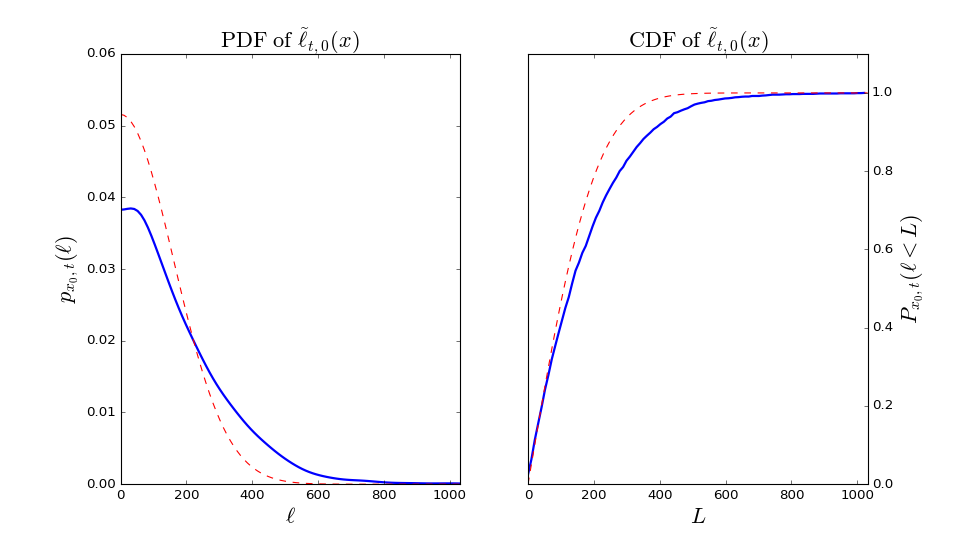

In [570]:
space_index   = 1
dataB         = LB[Pr_ind,space_index,:,1]
dataT         = LT[Pr_ind,space_index,:,1]
MB            = np.max(dataB)
MT            = np.max(dataT)

fig = plt.figure(figsize=(8,4))

ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
fig.subplots_adjust(hspace=.6)

####################################
######## BOTTOM LOCAL TIME #########
####################################
deltas = np.linspace(1, MB/20, 20)

NN = 100
bins = np.linspace(0, MB, NN)
pdf = approximatePDF(40, dataB, bins)

weights = np.ones_like(dataB[:])/nparticles
#ax1.hist(dataB, weights = weights, bins = bins, alpha=0.5, histtype = 'step',  color='blue')
ax1.plot(bins, pdf[len(bins):],  color='blue',lw = 2)
analyticalPDF = (localTimePDF(bins, 0, t[0]) )/np.trapz(localTimePDF(bins, 0, t[0]))
ax1.plot(bins, analyticalPDF, 'r--')

ax1.set_title('$\\rm PDF\  of$ $\\tilde{\\ell}_{t,0}(x)$', fontsize=20)
ax1.set_xlim([0,MB])
ax1.set_xlabel('$\ell$', fontsize=20)
ax1.set_ylabel('$p_{x_0,t}(\\ell)$', fontsize=20)

values, base = np.histogram(dataB, bins = NN, normed = 0)
cumulative   = np.cumsum(values)/float(dataB.shape[0])
ax2.plot(base[:-1], cumulative, c='blue', lw = 2)
ax2.plot(bins, localTimeCDF(bins, 0, t[0]), 'r--')

ax2.set_xlim([0,MB])
ax2.set_ylim([0,1.1])
ax2.set_title('$\\rm CDF\  of$ $\\tilde{\\ell}_{t,0}(x)$', fontsize=20)
ax2.set_xlabel('$L$', fontsize=20)
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
ax2.set_ylabel('$P_{x_0,t}(\\ell<L)$', fontsize=20)

<IPython.core.display.Javascript object>


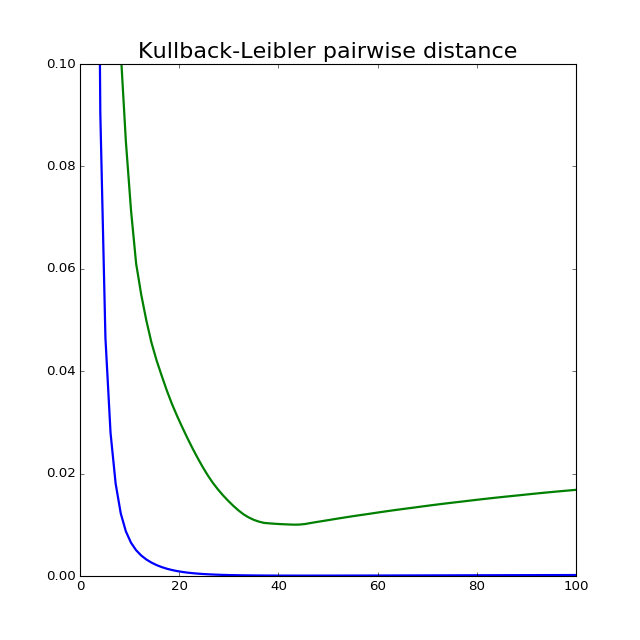

In [418]:
deltas = np.linspace(1, MB/10, 100)
L1, KS = get_pairwise_dist(deltas, dataB, bins)

fig  = plt.figure(figsize=(8,8))
ax   = fig.add_subplot(111)
ax.plot(deltas[1:], KS/max(KS), lw = 2)
ax.plot(deltas[1:], L1/max(L1), lw = 2)
ax.set_xlim([0,100])
ax.set_ylim([0,0.1])
ax.set_title('Kullback-Leibler pairwise distance', fontsize=20)


<IPython.core.display.Javascript object>


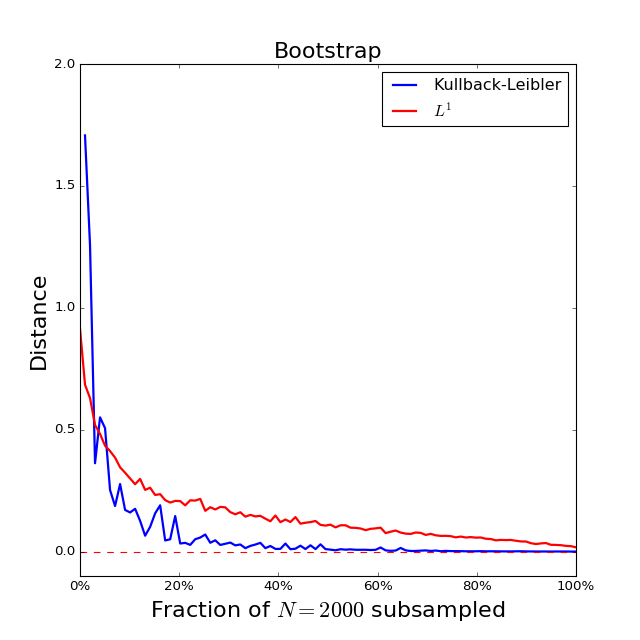

In [415]:
delta = deltas[6]
Nreps = 10
Ns   = np.array(range(20, 2020, 20))
perc = np.linspace(0,100,len(Ns))

L1, KS = subsampled_dist(Ns, Nreps, delta, dataB, bins)


fig  = plt.figure(figsize=(8,8))
ax   = fig.add_subplot(111)
ax.plot(perc, KS, c='blue', lw = 2, label = 'Kullback-Leibler')
ax.plot(perc, L1, c='red', lw = 2, label = '$L^1$')
ax.plot(perc, np.zeros(shape=100), 'r--', lw = 1)
ax.set_xlim([0,max(perc)])
ax.set_ylim([-.1,2])
ax.set_title('Bootstrap', fontsize=20)
ax.set_xlabel('Fraction of $N=2000$ subsampled', fontsize=20)
ax.set_ylabel('Distance', fontsize=20)
legend = ax.legend(loc='upper right')

fmt = '%.0f%%' # Format you want the ticks, e.g. '40%'
xticks = mtick.FormatStrFormatter(fmt)
ax.xaxis.set_major_formatter(xticks)
#ax.set_xscale('log')

In [431]:
####### Load Data #######
t   = get_timeline('channel', subdiv = 3) #make sure subdiv is same here as in data
tau = t[0] - t
PrandtlNumbers = np.array([1e0, 1e-1, 1e-2, 1e-3])   

npoints    = 1
nparticles = 2000
suffix1 = '_Points_{0}_Traj_{1}_Pr_{2}.p'.format(npoints, nparticles, PrandtlNumbers[0])
suffix2 = '_Points_{0}_Traj_{1}_Pr_{2}.p'.format(npoints, nparticles, PrandtlNumbers[1])
suffix3 = '_Points_{0}_Traj_{1}_Pr_{2}.p'.format(npoints, nparticles, PrandtlNumbers[2])
LT1      = pickle.load( open( "data_channel/LT"    + suffix1, "rb" ) )
LB1      = pickle.load( open( "data_channel/LB"    + suffix1, "rb" ) )
HT1      = pickle.load( open( "data_channel/HT"    + suffix1, "rb" ) )
disp1    = pickle.load( open( "data_channel/disp"  + suffix1, "rb" ) )
LT2      = pickle.load( open( "data_channel/LT"    + suffix2, "rb" ) )
LB2      = pickle.load( open( "data_channel/LB"    + suffix2, "rb" ) )
HT2      = pickle.load( open( "data_channel/HT"    + suffix2, "rb" ) )
disp2    = pickle.load( open( "data_channel/disp"  + suffix2, "rb" ) )

<IPython.core.display.Javascript object>


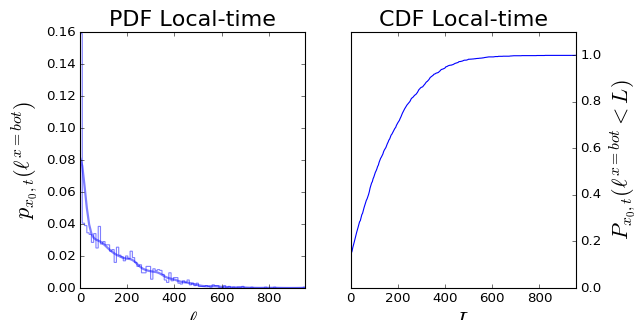

In [457]:
space_index   = 0
dataB         = LB2[space_index,:,1]
dataT         = LT2[space_index,:,1]
MB            = np.max(dataB)
MT            = np.max(dataT)

fig = plt.figure(figsize=(8,4))

ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
fig.subplots_adjust(hspace=.5)

####################################
######## BOTTOM LOCAL TIME #########
####################################

NN = 100
bins = np.linspace(0, MB, NN)

pdf = approximatePDF(20, dataB, bins)
N = nparticles
weights = np.ones_like(dataB[:])/N
ax1.hist(dataB, weights = weights, bins = bins, alpha=0.5, histtype = 'step')
ax1.plot(bins, pdf[len(bins):], color='blue', alpha = 0.5, lw = 2)

ax1.set_title('PDF Local-time', fontsize=20)
ax1.set_xlim([0,MB])
ax1.set_xlabel('$\ell$', fontsize=20)
ax1.set_ylabel('$p_{x_0,t}(\\ell^{x=bot})$', fontsize=20)

values, base = np.histogram(dataB, bins = 300, normed = 0)
cumulative   = np.cumsum(values)/float(dataB.shape[0])
ax2.plot(base[:-1], cumulative, c='blue')

ax2.set_xlim([0,MB])
ax2.set_ylim([0,1.1])
ax2.set_title('CDF Local-time', fontsize=20)
ax2.set_xlabel('$L$', fontsize=20)
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
ax2.set_ylabel('$P_{x_0,t}(\\ell^{x=bot}<L)$', fontsize=20)

<IPython.core.display.Javascript object>


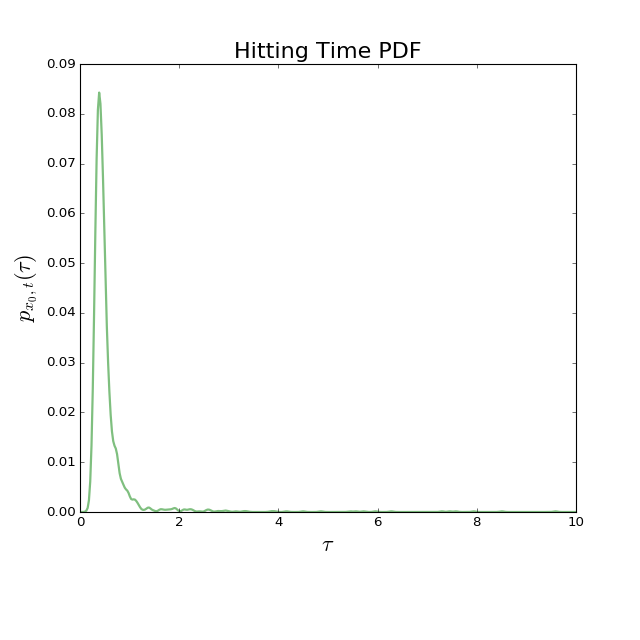

In [569]:
def stoppingTimePDF(tau, x0, kappa):
    return x0*np.exp(-x0**2/(4*kappa*tau))/np.sqrt(4*np.pi*kappa*tau**3)

space_index = 0
T = t[0]
data1 = HT1[space_index, :, np.newaxis]
data1 = data1[data1 < 2*T]
data2 = HT2[space_index, :, np.newaxis]
data2 = data2[data2 < 2*T]
MD = np.max(data2)

NN = 1000
bins = np.linspace(0, MD, NN)

delta = .04
HTpdf1 = approximatePDF(delta, data1, bins)
HTpdf2 = approximatePDF(delta, data2, bins)

fig = plt.figure(figsize=(8,8))
ax1 = fig.add_subplot(111)
fig.subplots_adjust(hspace=.5)

plt.gcf().subplots_adjust(bottom=0.2)

weights1 = np.ones_like(data1[:])/nparticles
#weights2 = np.ones_like(data2[:])/nparticles
#ax1.hist(data1, weights = weights1, bins = NN, alpha=0.5,  histtype = 'step', color='green')
#ax1.hist(data2, weights = weights2, bins = NN, alpha=0.5,  histtype = 'step', color='red')

ax1.plot(bins, HTpdf1[len(bins):], color='green', alpha = 0.5, lw = 2)
#ax1.plot(bins, HTpdf2[len(bins):], color='red',   alpha = 0.5, lw = 2)
#ax1.plot(bins, stoppingTimePDF(bins, 0.05, nu/PrandtlNumbers[0])/np.trapz(stoppingTimePDF(bins[1:], 0.05, nu/PrandtlNumbers[0])), 'g--')
#ax1.plot(bins, stoppingTimePDF(bins, 0.05, nu/PrandtlNumbers[1])/np.trapz(stoppingTimePDF(bins[1:], 0.05, nu/PrandtlNumbers[1])), 'r--')

#ax1.plot(bins, stoppingTimePDF(bins, 0.05, .02)/np.trapz(stoppingTimePDF(bins[1:], 0.05, .02)), 'r--')
#ax1.plot(bins, stoppingTimePDF(bins, 0.05, 10**(-3))/np.trapz(stoppingTimePDF(bins[1:], 0.05,  10**(-3))), 'g--')

taus = np.linspace(0.001, T, 350)
ax1.set_title('Hitting Time PDF', fontsize=20)
ax1.set_xlim([0, 10])
#ax1.set_ylim([0, max(HTpdf1[len(bins):])+0.02])
ax1.set_xlabel('$\\tau$', fontsize=20)
ax1.set_ylabel('$p_{x_0,t}(\\tau)$', fontsize=20)

<IPython.core.display.Javascript object>


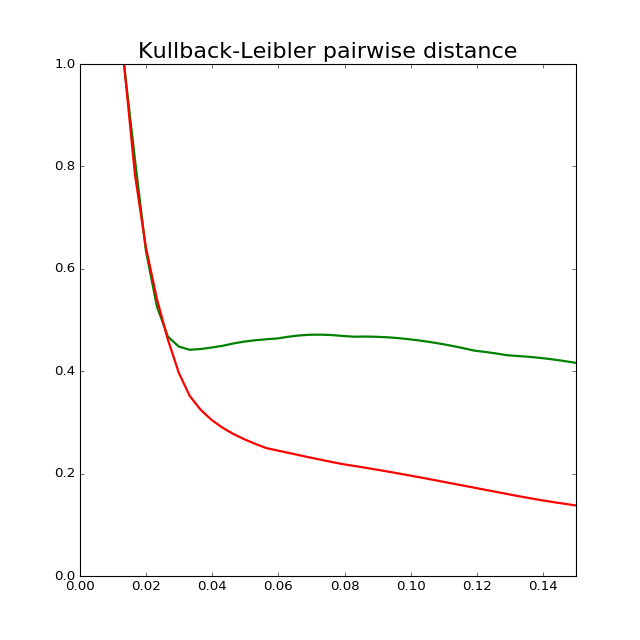

In [546]:
deltas = np.linspace(0.01, 1, 300)
L11, KS1 = get_pairwise_dist(deltas, data1[1:], bins)
L12, KS2 = get_pairwise_dist(deltas, data2[1:], bins)

fig  = plt.figure(figsize=(8,8))
ax   = fig.add_subplot(111)
#ax.plot(deltas[1:], KS1/max(KS1), lw = 2, color = 'green')
#ax.plot(deltas[1:], KS2/max(KS2), lw = 2, color = 'red')
ax.plot(deltas[1:], L11/max(L11), lw = 2, color = 'green')
ax.plot(deltas[1:], L12/max(L12), lw = 2, color = 'red')
ax.set_xlim([0,.15])
#ax.set_ylim([0,0.1])
ax.set_title('Kullback-Leibler pairwise distance', fontsize=20)

<IPython.core.display.Javascript object>


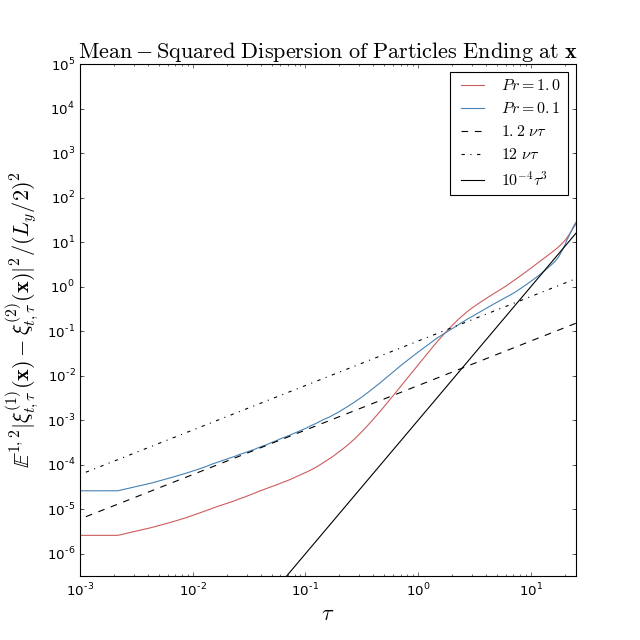

In [463]:
space_point_index = 0
kolmogorov_time = 1

half_Channel_Width = 0.5*(Top-Bottom)

kappa1 = nu/PrandtlNumbers[1]
kappa2 = nu/PrandtlNumbers[2]

Tau = tau/float(kolmogorov_time)
diffusion_dispersion1 = 12*kappa1*Tau
diffusion_dispersion2 = 12*kappa2*Tau
#diffusion_dispersion3 = 12*kappa3*Tau
Richardson_dispersion = 1e-3*Tau**3

disper1 = disp1[:, space_point_index]/float(half_Channel_Width**2)
disper2 = disp2[:, space_point_index]/float(half_Channel_Width**2)
#disper3 = disp[2,:, space_point_index]/float(half_Channel_Width**2)

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
ax.plot(Tau, disper1, color = 'Indianred', label = '$Pr = {0}$'.format(PrandtlNumbers[0]))
ax.plot(Tau, disper2, color = 'Steelblue', label = '$Pr = {0}$'.format(PrandtlNumbers[1]))
#ax.plot(Tau, disper3, color = 'green', label = '$Pr = {0}$'.format(PrandtlNumbers[2]))
ax.plot(Tau, diffusion_dispersion1,   color = 'black', linestyle = 'dashed',  label = '$1.2\ \\nu\\tau$')
ax.plot(Tau, diffusion_dispersion2,   color = 'black', linestyle = 'dashdot', label = '$12\  \\nu \\tau$')
#ax.plot(Tau, diffusion_dispersion3,   color = 'black', linestyle = 'dotted',  label = '$120\  \\nu \\tau$')
ax.plot(Tau, Richardson_dispersion,   color = 'black', linestyle = 'solid',   label = '$10^{-4} \\tau^3$')
ax.set_xlim([10**(-3),10**(1.4)])
ax.set_ylim([10**(-6.5),10**(5)])
ax.set_title('$\\rm Mean-Squared\ Dispersion\ of\ Particles\ Ending\ at\ \\mathbf{x}$', fontsize=20)
ax.set_xlabel('$\\tau $', fontsize=20)
ax.set_ylabel('$\mathbb{E}^{1,2} |{\\xi}^{(1)}_{t,\\tau}(\\mathbf{x})-{\\xi}^{(2)}_{t,\\tau}(\\mathbf{x})|^2 /(L_y/2)^2$', fontsize=20)
ax.set_yscale('log')
ax.set_xscale('log')
ax.legend(loc ="best")